In [1]:
import os
import sys
import glob

sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand")
sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D")

from dataloader_ann import HandArmLandmarksDataset_ANN

import numpy as np
from torch.utils.data import DataLoader
import os
from datetime import datetime
import math
import open3d as o3d
from utilities import convert_to_shoulder_coord
import time
import pandas as pd
from csv_writer import fusion_csv_columns_name
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import threading
import queue

from angle_calculation_v2 import calculate_angle_j1
from angle_calculation_v2 import calculate_six_arm_angles, rotation_matrix_for_elbow
from send_data_to_robot import send_udp_message

%matplotlib notebook

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
DATA_DIR = "/home/giakhang/dev/pose_sandbox/data"  
SELECTED_DATE = "*"  # Keep '*' when using glob.glob

train_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "train")))
val_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "val")))

#fake_train_paths = glob.glob(os.path.join(DATA_DIR, "fake_data", "train", "fake_*.csv"))

#if len(fake_train_paths) > 0:
    #train_paths.extend(fake_train_paths)

body_lines = [[0,2], [0, 3], [2, 4], [3, 4]]
lefthand_lines = [[0, 1], [1, 5], [5, 6], [5, 10], [5, 22], [10, 14], [14, 18], [18, 22], 
    [6, 7], [7, 8], [8, 9], 
    [10, 11], [11, 12], [12, 13], 
    [14, 15], [15, 16], [16, 17], 
    [18, 19], [19, 20], [20, 21], 
    [22, 23], [23, 24], [24, 25]]
train_body_distance_thres = 550
train_leftarm_distance_thres = 550
train_lefthand_distance_thres = 200
val_body_distance_thres = 450
val_leftarm_distance_thres = 450
val_lefthand_distance_thres = 150

train_dataset = HandArmLandmarksDataset_ANN(train_paths, 
    body_lines, 
    lefthand_lines, 
    train_body_distance_thres, 
    train_leftarm_distance_thres, 
    train_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataset = HandArmLandmarksDataset_ANN(val_paths,
    body_lines,
    lefthand_lines,
    val_body_distance_thres,
    val_leftarm_distance_thres,
    val_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)  

In [3]:
train_dataset._outputs.shape

(3867, 144)

In [4]:
arm_hand_fused_names = ["left shoulder", "left elbow", "left hip", "right shoulder", "right hip", 
 "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", "INDEX_FINGER_MCP", 
 "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", 
 "MIDDLE_FINGER_PIP", "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
 "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", "PINKY_MCP", "PINKY_PIP", 
 "PINKY_DIP", "PINKY_TIP", "right elbow"]

In [5]:
target_output = train_dataset._outputs  #  shape: (N, 144)
sample = target_output[4]  # shape: (144)
sample = sample.reshape(3, 48)  # shape: (3, 48)
sample = sample.T  # shape: (48, 3)
sample = sample[:26]  # shape: (26, 3)

In [6]:
body_lines = [[0,2], [0, 3], [2, 4], [3, 4]]
lefthand_lines = [[0, 1], [1, 5], [5, 6], [5, 10], [5, 22], [10, 14], [14, 18], [18, 22], 
    [6, 7], [7, 8], [8, 9], 
    [10, 11], [11, 12], [12, 13], 
    [14, 15], [15, 16], [16, 17], 
    [18, 19], [19, 20], [20, 21], 
    [22, 23], [23, 24], [24, 25]]
lines = body_lines.copy()
lines.extend(lefthand_lines)

In [7]:
pts, original_xyz = convert_to_shoulder_coord(sample, arm_hand_fused_names)

In [8]:
colors = [[0, 0, 0] for i in range(len(lines))]

angles, rot_mats_wrt_origin, rot_mats_wrt_parent = calculate_six_arm_angles(pts,
        original_xyz,
        arm_hand_fused_names)
angle_j1, angle_j2, angle_j3, angle_j4, _, _ = angles
j1_rm, j2_rm, j3_rm, j4_rm, _, _ = rot_mats_wrt_origin
j1_rm_wrt_parent, j2_rm_wrt_parent, j3_rm_wrt_parent, j4_rm_wrt_parent, _, _ = rot_mats_wrt_parent

"""
# Draw original xyz
x_unit, y_unit, z_unit = original_xyz[:, 0], original_xyz[:, 1], original_xyz[:, 2]
pts = np.concatenate([pts, [x_unit * 40, y_unit * 40, z_unit * 40]], axis=0)
last_index = pts.shape[0] - 1
lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
"""


# Plot j1
"""
x_j1, y_j1, z_j1 = j1_rm[:, 0],  j1_rm[:, 1], j1_rm[:, 2]
pts = np.concatenate([pts, [x_j1 * 40, y_j1 * 40, z_j1 * 40]], axis=0)
last_index = pts.shape[0] - 1
lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
"""

# Plot j2
"""
x_j2, y_j2, z_j2 = j2_rm[:, 0],  j2_rm[:, 1], j2_rm[:, 2]
pts = np.concatenate([pts, [x_j2 * 40, y_j2 * 40, z_j2 * 40]], axis=0)
last_index = pts.shape[0] - 1
lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
"""

j2_p_rm = j2_rm @ rotation_matrix_for_elbow 
x_j2_p_rm, y_j2_p_rm, z_j2_p_rm = j2_p_rm[:, 0], j2_p_rm[:, 1], j2_p_rm[:, 2]
pts = np.concatenate([pts, [x_j2_p_rm * 40, y_j2_p_rm * 40, z_j2_p_rm * 40]], axis=0)
last_index = pts.shape[0] - 1
lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])


# Plot j3
x_j3, y_j3, z_j3 = j3_rm[:, 0],  j3_rm[:, 1], j3_rm[:, 2]
pts = np.concatenate([pts, [x_j3 * 40, y_j3 * 40, z_j3 * 40]], axis=0)
last_index = pts.shape[0] - 1
lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

# Plot j4
"""
x_j4, y_j4, z_j4 = j4_rm[:, 0],  j4_rm[:, 1], j4_rm[:, 2]
pts = np.concatenate([pts, [x_j4 * 40, y_j4 * 40, z_j4 * 40]], axis=0)
last_index = pts.shape[0] - 1
lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
"""

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)

line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(pts),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd, line_set])

print(angle_j4)

-5.809452077478107


In [8]:
DATA_DIR = "/home/giakhang/dev/pose_sandbox/data"  
SELECTED_DATE = "*"  # Keep '*' when using glob.glob

train_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "train")))

In [14]:
train_paths = [train_paths[-1]]
train_dataset = HandArmLandmarksDataset_ANN(train_paths, 
    body_lines, 
    lefthand_lines, 
    train_body_distance_thres, 
    train_leftarm_distance_thres, 
    train_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True)

ground_truth_data = train_dataset._outputs

In [15]:
TARGET_ANGLES_QUEUE = queue.Queue()
TARGET_ANGLES_QUEUE.put((np.zeros(6), 1))

In [ ]:
fps = 12
time_sleep = 1
target_output = ground_truth_data  # shape: (N, 144)
x = np.array([[500, 0, 0],
    [0, 0, 0]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(x)
lines = [[0, 0]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(x),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[500,0 ,0], [0, 0, 0]])),
    lines=o3d.utility.Vector2iVector([[0, 0]])
)
    
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(line_set)
#vis.add_geometry(bounding_box)

j1_angles = []
j2_angles = []
j3_angles = []
j4_angles = []

for i in range(target_output.shape[0]):
    output = target_output[i, ...]  # shape: (144)
    output = output.reshape(3, 48)  # shape: (3, 48)
    output = output.T  # shape: (48, 3)
    output = output[:26, ...]  # shape: (26, 3)

    lines = body_lines.copy()
    lines.extend(lefthand_lines)
    colors = [[0, 0, 0] for i in range(len(lines))]

    points, original_xyz = convert_to_shoulder_coord(output,
        arm_hand_fused_names)
    
    angles, rot_mats_wrt_origin, rot_mats_wrt_parent = calculate_six_arm_angles(points,
        original_xyz,
        arm_hand_fused_names)
    angle_j1, angle_j2, angle_j3, angle_j4, _, _ = angles
    j1_rm, j2_rm, j3_rm, j4_rm, _, _ = rot_mats_wrt_origin
    j1_rm_wrt_parent, j2_rm_wrt_parent, j3_rm_wrt_parent, j4_rm_wrt_parent, _, _ = rot_mats_wrt_parent

    # Draw original xyz
    """
    x_unit, y_unit, z_unit = original_xyz[:, 0], original_xyz[:, 1], original_xyz[:, 2]
    points = np.concatenate([points, [x_unit * 40, y_unit * 40, z_unit * 40]], axis=0)
    last_index = points.shape[0] - 1
    lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
    colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    """
    
    # Draw j1 xyz
    """
    x_j1, y_j1, z_j1 = j1_rm[:, 0],  j1_rm[:, 1], j1_rm[:, 2]
    points = np.concatenate([points, [x_j1 * 40, y_j1 * 40, z_j1 * 40]], axis=0)
    last_index = points.shape[0] - 1
    lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
    colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    j1_angles.append(angle_j1)
    """
    
    # Draw j2 xyz
    """
    x_j2, y_j2, z_j2 = j2_rm[:, 0],  j2_rm[:, 1], j2_rm[:, 2]
    points = np.concatenate([points, [x_j2 * 40, y_j2 * 40, z_j2 * 40]], axis=0)
    last_index = points.shape[0] - 1
    lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
    colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    j2_angles.append(angle_j2)
    """
    
    j2_p_rm = j2_rm @ rotation_matrix_for_elbow
    x_j2_p_rm, y_j2_p_rm, z_j2_p_rm = j2_p_rm[:, 0], j2_p_rm[:, 1], j2_p_rm[:, 2]
    points = np.concatenate([points, [x_j2_p_rm * 40, y_j2_p_rm * 40, z_j2_p_rm * 40]], axis=0)
    last_index = points.shape[0] - 1
    lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
    colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    
    # Draw j3 xyz
    x_j3, y_j3, z_j3 = j3_rm[:, 0],  j3_rm[:, 1], j3_rm[:, 2]
    points = np.concatenate([points, [x_j3 * 40, y_j3 * 40, z_j3 * 40]], axis=0)
    last_index = points.shape[0] - 1
    lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
    colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    j3_angles.append(angle_j3)
    
    
    # Draw j4 xyz
    """
    x_j4, y_j4, z_j4 = j4_rm[:, 0],  j4_rm[:, 1], j4_rm[:, 2]
    points = np.concatenate([points, [x_j4 * 40, y_j4 * 40, z_j4 * 40]], axis=0)
    last_index = points.shape[0] - 1
    lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
    colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    j4_angles.append(angle_j4)
    """
 
    # Draw cuboid
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    vertices = [
        [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
        [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
    ]
    vertices = np.array(vertices) 
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  
        [4, 5], [5, 7], [7, 6], [6, 4],  
        [0, 4], [1, 5], [2, 6], [3, 7]   
    ]
    bounding_box.points = o3d.utility.Vector3dVector(vertices)
    bounding_box.lines = o3d.utility.Vector2iVector(edges)
    bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
    bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

    pcd.points = o3d.utility.Vector3dVector(points)
    line_set.points = o3d.utility.Vector3dVector(points)  
    line_set.lines = o3d.utility.Vector2iVector(lines) 
    line_set.colors = o3d.utility.Vector3dVector(colors)

    vis.update_geometry(pcd)
    vis.update_geometry(line_set)
    #vis.update_geometry(bounding_box)
    vis.poll_events()
    vis.update_renderer()
    
    # Send UDP message
    arm_angles = np.array([angle_j1, angle_j2, angle_j3, angle_j4, 0, 0])
    TARGET_ANGLES_QUEUE.put((arm_angles, i))
    if TARGET_ANGLES_QUEUE.qsize() > 1:
        TARGET_ANGLES_QUEUE.get()
        
    time.sleep(time_sleep)

vis.destroy_window()

In [11]:
send_data_thread = threading.Thread(target=send_udp_message, args=(TARGET_ANGLES_QUEUE,
    True, 0.5,), daemon=True)
send_data_thread.start()

<IPython.core.display.Javascript object>


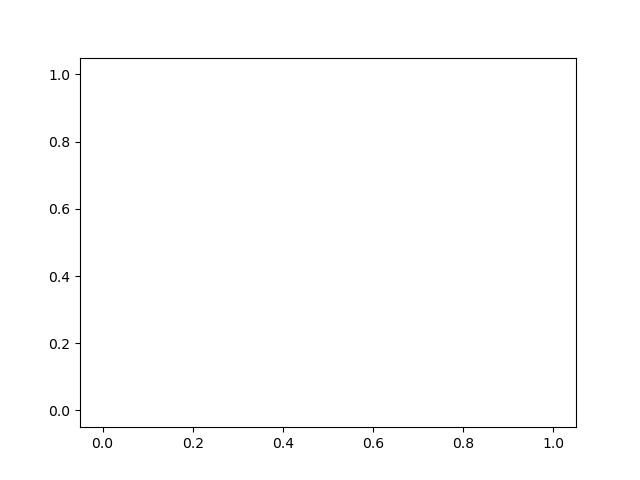

In [21]:
_ = plt.figure()
plt.scatter(range(0, len(j1_angles)), j1_angles, sizes=[6] * len(j1_angles))
plt.show()

<IPython.core.display.Javascript object>


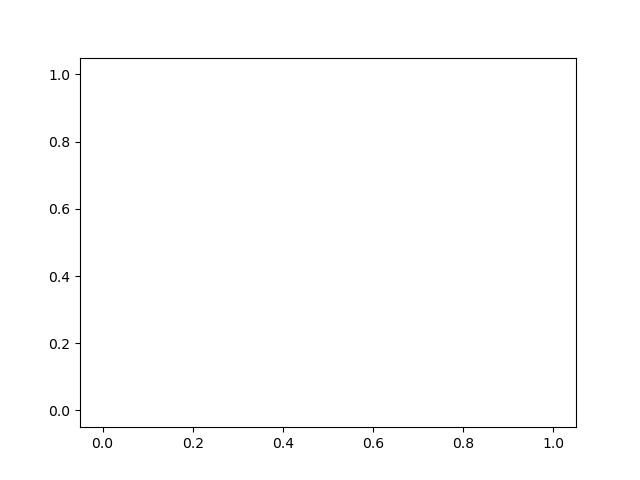

In [22]:
_ = plt.figure()
plt.scatter(range(0, len(j2_angles)), j2_angles, sizes=[6] * len(j2_angles), color='orange')
plt.show()

<IPython.core.display.Javascript object>


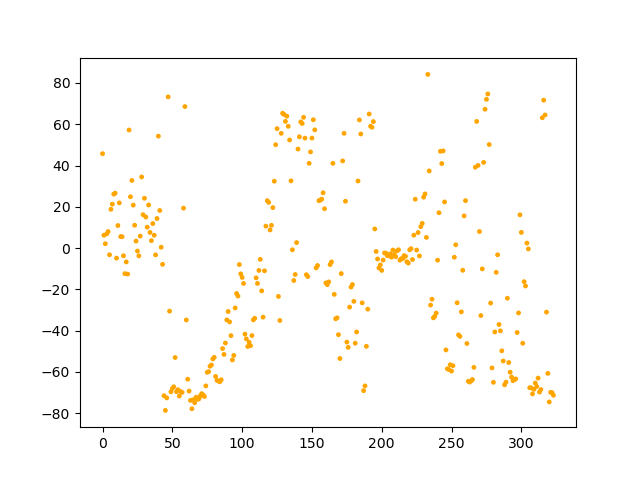

In [23]:
_ = plt.figure()
plt.scatter(range(0, len(j3_angles)), j3_angles, sizes=[6] * len(j3_angles), color='orange')
plt.show()

<IPython.core.display.Javascript object>


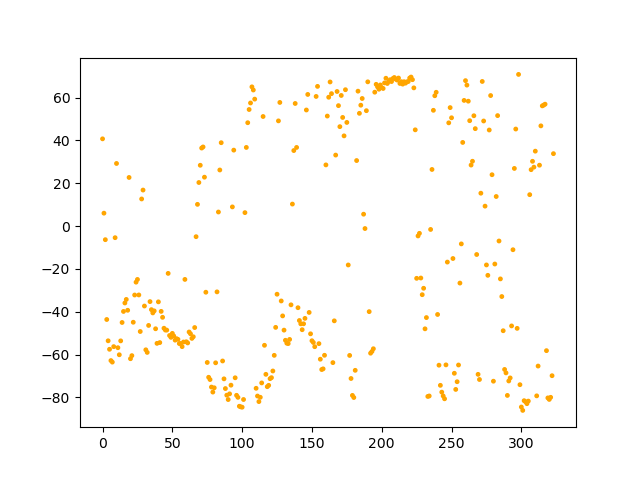

In [12]:
_ = plt.figure()
plt.scatter(range(0, len(j4_angles)), j4_angles, sizes=[6] * len(j4_angles), color='orange')
plt.show()

In [9]:
j3_rm

array([[-0.05354115,  0.14672407, -0.98772739],
       [-0.8573289 , -0.51390191, -0.02986594],
       [-0.51197705,  0.84520818,  0.15330569]])

In [11]:
j4_rm_wrt_parent

array([[ 0.99486402, -0.        ,  0.10122042],
       [ 0.        ,  1.        ,  0.        ],
       [-0.10122042,  0.        ,  0.99486402]])